# Libraries

In [80]:
import csv
import os
import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [7]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Title

        url = data[0]["url"]  # URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue  # Blacklist (Bob Dylan's case)

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100:
            continue  # Filter max
        if len(entities) <= 1:
            continue  # Filter min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            # print('name', name)
            cleaned = re.sub(r"\([^()]*\)", "", name)  # Remove brackets with text
            name = cleaned
            name = " ".join(name.split())  # Merge multiple spaces
            name = name.lstrip()  # Remove leading whitespaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            # print('name', name)

            if name in {"World Health Organisation"}:
                continue  # Stopwords

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "):
                    name = name[3:]  # Remove prefix
                if name.endswith(" Corp"):
                    name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"):
                    name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"):
                    name = name[:-4]  # Remive postfix
                if name[0].islower():
                    continue  # Remove lowercase
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[1].isupper():
                    continue  # Remove uppercase
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            )  # Add these articles with actors only

    except:
        continue  # In case of error


articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
).drop_duplicates(
    subset=["url"]
)  # Remove articles with the same URL

print("The number of articles is " + str(articles.shape[0]))

articles.sample(1)


The number of articles is 18126


,year,title,url,subjects,orgs,people
15219,2013,Biomass power generation scene smoky,http://timesofindia.indiatimes.com/city/vadoda...,"[electric light and power, energy and power, l...",[Gujarat Energy Development Agency],[V K Jain]


## Entities

In [8]:
entities = np.empty((0, 12), dtype=object)

years_template = {
    2011: 0,
    2012: 0,
    2013: 0,
    2014: 0,
    2015: 0,
    2016: 0,
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
}


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in articles.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:
        update(entity, "subject")

    for entity in row["orgs"]:
        update(entity, "org")

    for entity in row["people"]:
        update(entity, "person")

# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


The total number of entities is 68327


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
14,environment,subject,7492,NaN,None,-1,-1,-1,"{2011: 184, 2012: 147, 2013: 355, 2014: 484, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Imperial College of London, Ramachandra Unive..."


# Treatment

## Normalization

In [61]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
14505,Bristol Zoo,org,1,NaN,None,-1,-1,-1,"{2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, ...",[http://www.jerseyeveningpost.com/news/2017/10...,[Bats readied for return home],"[Jersey Zoo, animals, Dominic Wormell, Durrell...",0.0,"{""2011"": 0, ""2012"": 0, ""2013"": 0, ""2014"": 0, ""..."


## Filter

In [179]:
n = 50  # Number of rows by type

top_subjects = (
    entities_all.loc[entities_all["type"] == "subject"]
    .sort_values(by=["frequency"], ascending=False)
    .head(n * 3)
)
top_orgs = (
    entities_all.loc[entities_all["type"] == "org"]
    .sort_values(by=["frequency"], ascending=False)
    .head(n)
)
top_people = (
    entities_all.loc[entities_all["type"] == "person"]
    .sort_values(by=["frequency"], ascending=False)
    .head(n)
)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
893,waste materials and disposal,subject,298,NaN,None,-1,-1,-1,"{2011: 7, 2012: 3, 2013: 10, 2014: 20, 2015: 2...",[http://www.straitstimes.com/asia/south-asia/n...,[New Delhi's poisonous air a perennial crisis ...,"[Delhi Pollution Control Committee, trucks and...",0.039648,"{""2011"": 7, ""2012"": 3, ""2013"": 10, ""2014"": 20,..."


## Linear Regression

In [180]:
# For each

for i, row in entities.iterrows():

    x = list(row["years"].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, "slope"] = slope


# Average and slope difference for subjects

entities_subjects = entities.loc[entities["type"] == "subject"]
average_subjects = entities_subjects["slope"].mean()
for i, row in entities_subjects.iterrows():
    entities.at[i, "slope"] = row["slope"] - average_subjects


# Average and slope difference for people and organizations

entities_nosubjects = entities.loc[entities["type"] != "subject"]
average_nosubjects = entities_nosubjects["slope"].mean()
for i, row in entities_nosubjects.iterrows():
    entities.at[i, "slope"] = row["slope"] - average_nosubjects


# entities.sort_values(by=["slope"], ascending=False).head(1)
# average_subjects, average_nosubjects
entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
407,beverages,subject,56,-8.027273,None,-1,-1,-1,"{2011: 2, 2012: 2, 2013: 2, 2014: 5, 2015: 11,...",[https://www.prnewswire.com:443/news-releases/...,[Pharmco establishes largest storage capacity ...,"[alcoholic beverages, Pharmco brands, Frank Ri...",0.007342,"{""2011"": 2, ""2012"": 2, ""2013"": 2, ""2014"": 5, ""..."


## Colors

In [181]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] != "subject":
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors
    else:
        entities.at[i, "color"] = "#cccccc"  # Subjects

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
14,environment,subject,7492,150.348485,#cccccc,-1,-1,-1,"{2011: 184, 2012: 147, 2013: 355, 2014: 484, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Imperial College of London, Ramachandra Unive...",1.0,"{""2011"": 184, ""2012"": 147, ""2013"": 355, ""2014""..."


# Embedding

## Term Frequency

In [182]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


## UMAP

In [232]:
reducer = umap.UMAP(
    random_state=2,
    n_components=2,
    n_neighbors=4,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
406,alcoholic beverages,subject,33,-8.263636,#cccccc,475,459,-1,"{2011: 0, 2012: 1, 2013: 0, 2014: 4, 2015: 8, ...",[https://www.prnewswire.com:443/news-releases/...,[Pharmco establishes largest storage capacity ...,"[Pharmco brands, Frank Richards, Steve DiBened...",0.004272,"{""2011"": 0, ""2012"": 1, ""2013"": 0, ""2014"": 4, ""..."


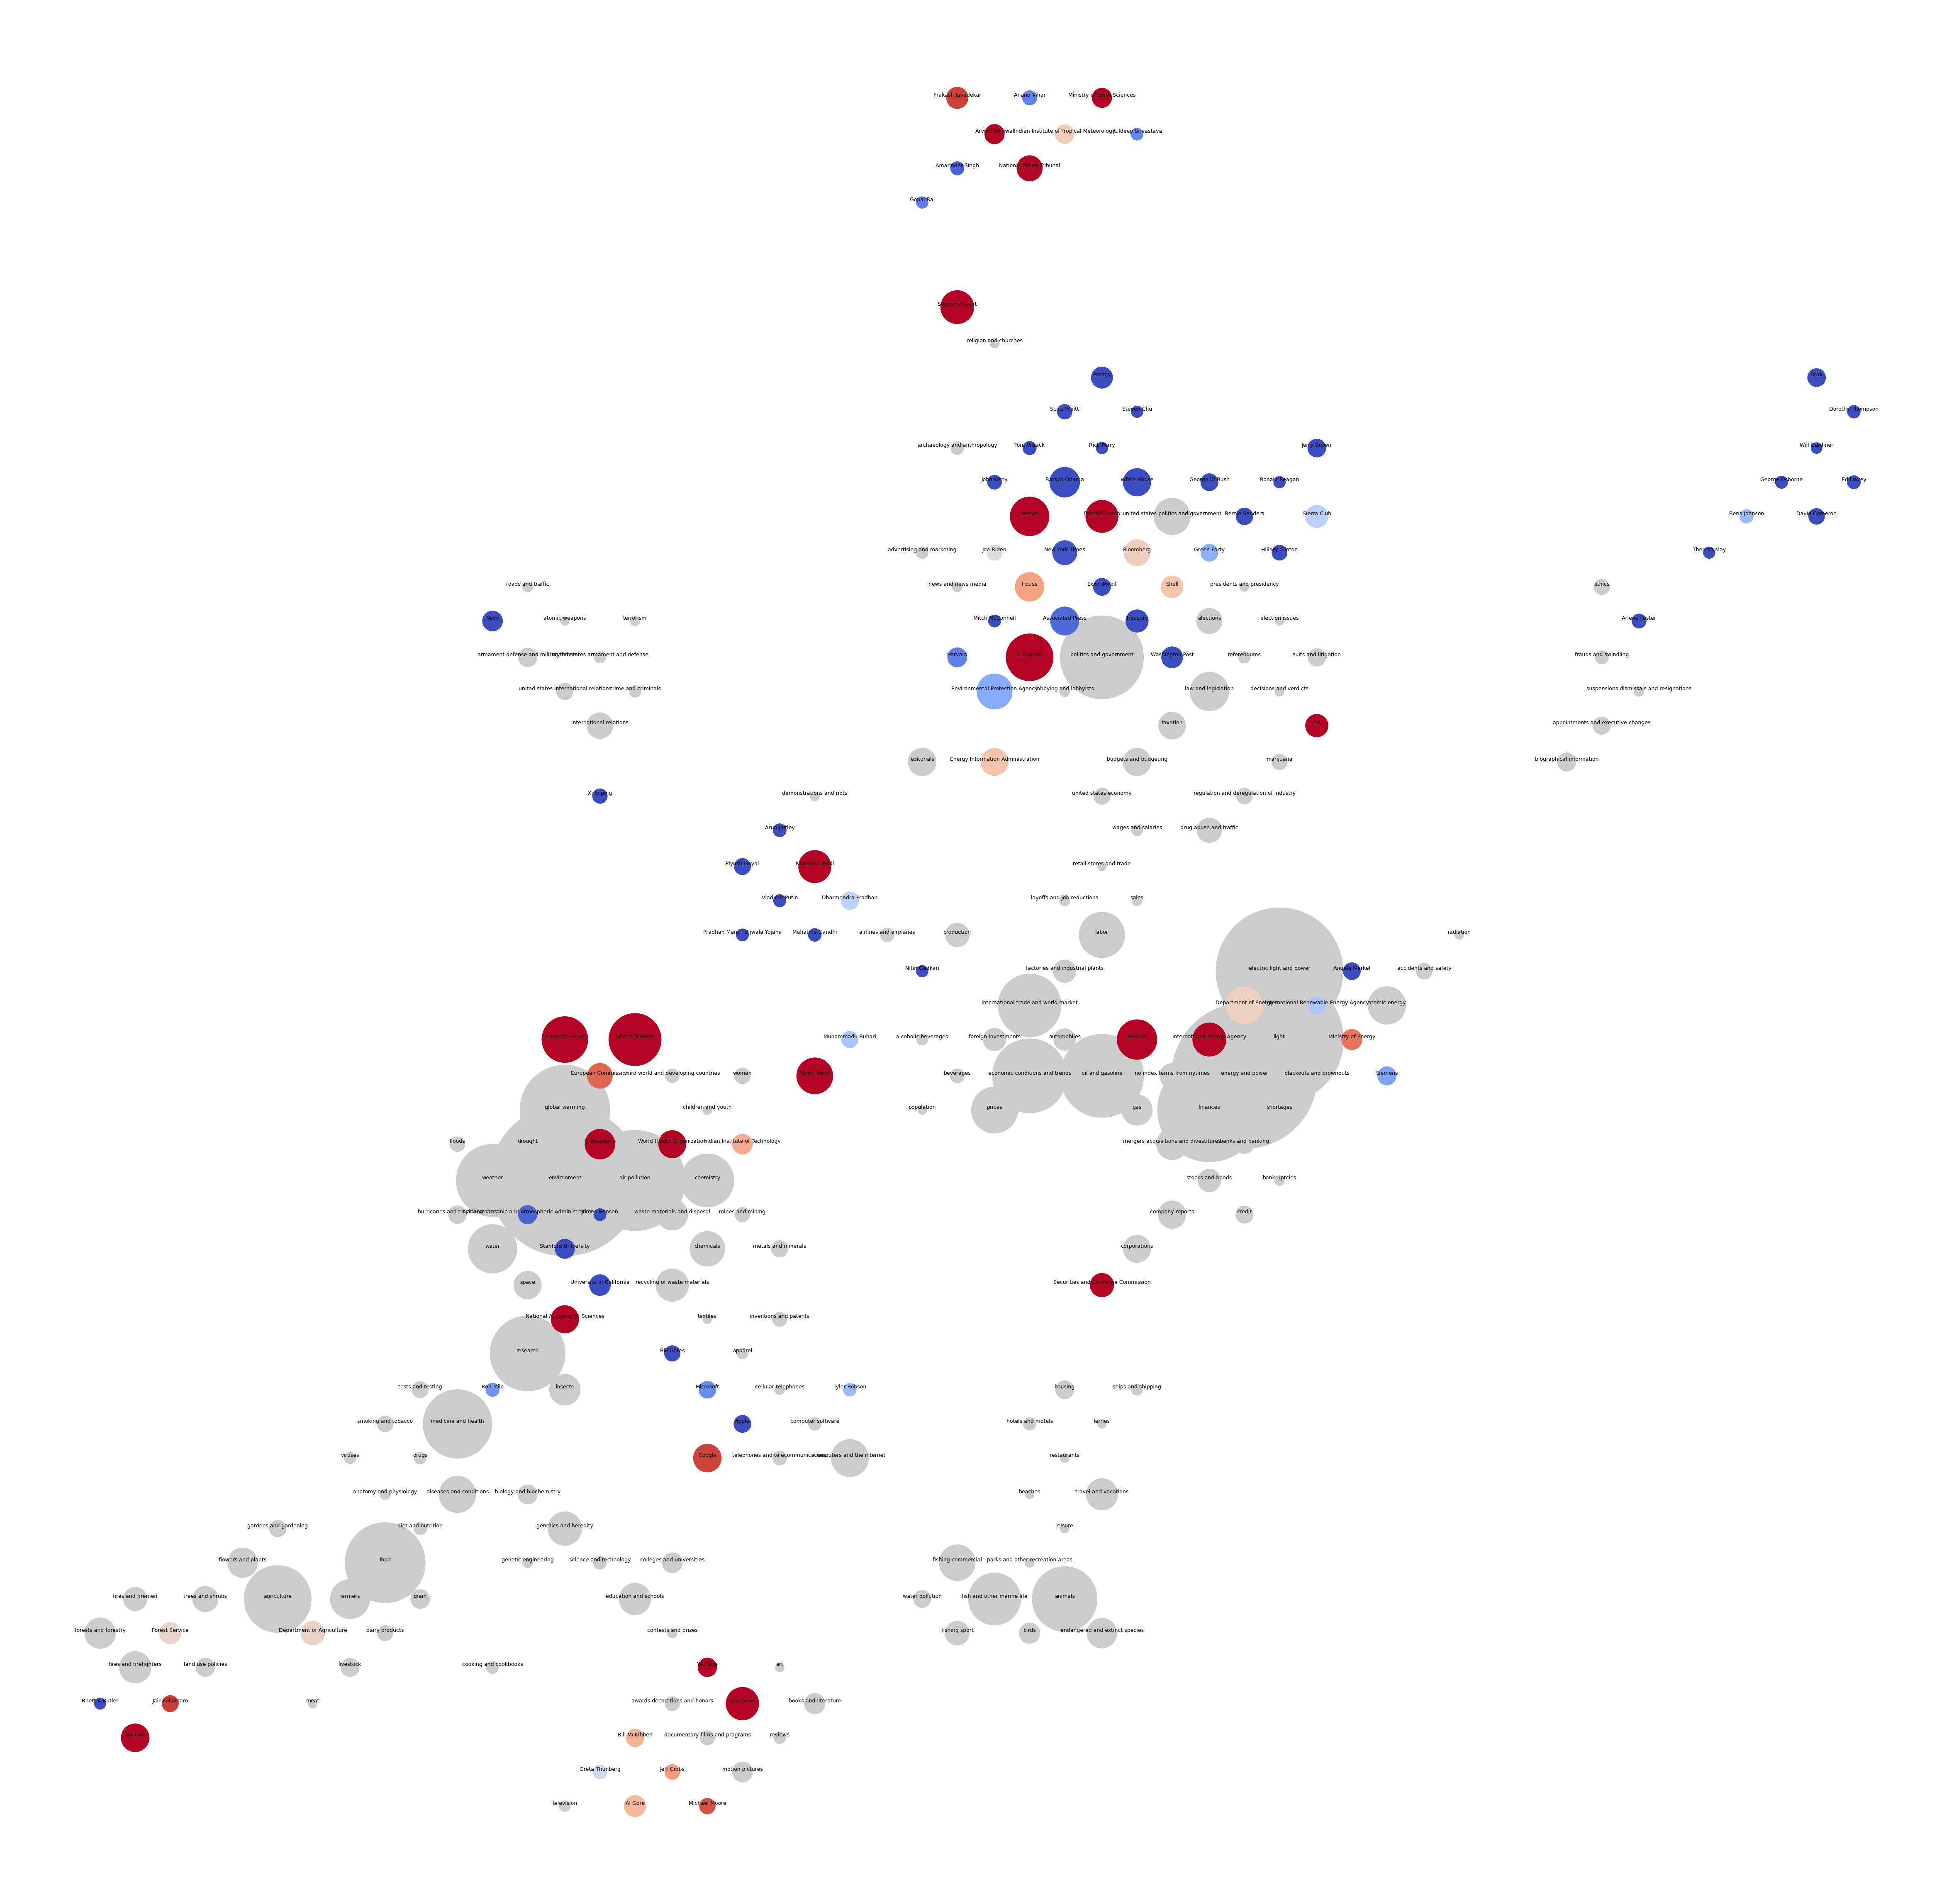

In [233]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [234]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=1,
    min_cluster_size=2,  # 2 — which means 3 elements — is the smallest cluster size
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
942,chemistry,subject,903,8.718182,#cccccc,377,393,-1,"{2011: 21, 2012: 17, 2013: 37, 2014: 69, 2015:...",[https://www.theguardian.com/environment/2020/...,"[Carbon capture 'moonshot' moves closer, as bi...","[finances, Arizona State University, air pollu...",0.120411,"{""2011"": 21, ""2012"": 17, ""2013"": 37, ""2014"": 6..."


{'-1', 'n_0', 'p_0', 'n_3', 'p_2', 'n_1', 'p_3', 'p_4', 'n_5', 'n_2', 'p_5', 'n_4', 'p_1'}


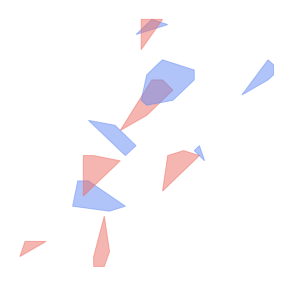

In [235]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [236]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
110,European Union,org,671,9.257576,#b40426,312,459,p_5,[https://www.theguardian.com/world/commentisfr...,0.089441,"{""2011"": 19, ""2012"": 15, ""2013"": 43, ""2014"": 5..."
